In [8]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split #for data splitting
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from scipy import stats
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.metrics import accuracy_score
from pdpbox import pdp, get_dataset, info_plots
from sklearn.tree import export_graphviz #plot tree
import eli5
from eli5.sklearn import PermutationImportance
import graphviz
os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin'

In [2]:
url='http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
df = pd.read_csv(url,sep= ',', header = None)
columns_name = ['age', 'sex', 'chest_pain_type', 'resting_bp', 'cholesterol', 'fasting_bld_sugar', 'rest_ecg', 'max_hrtrte_ach'
              ,'exer_indc_angina', 'st_depression', 'st_slope','no_mjr_vssels', 'thalassemia', 'target']
df.columns=columns_name
df['target'] = df.target.map({0: 0, 1: 1, 2: 1, 3: 1, 4: 1})
df = df.replace({'?':np.NaN})
df.dropna(inplace=True)
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', 1), df['target'], test_size = .2, random_state=10) #split the data
feature_names = [i for i in X_train.columns]
print(columns_name)
columns_name.remove('target')
X=df[columns_name]

['age', 'sex', 'chest_pain_type', 'resting_bp', 'cholesterol', 'fasting_bld_sugar', 'rest_ecg', 'max_hrtrte_ach', 'exer_indc_angina', 'st_depression', 'st_slope', 'no_mjr_vssels', 'thalassemia', 'target']


In [10]:
rf_model = RandomForestClassifier(random_state=1)
rf_model.fit(X_train, y_train)

rfc = RandomForestClassifier(n_estimators=100, random_state=100)

### One of the parameters we will be tuning is max_features. Let's find out the maximum value this could take:how many features do we have in our dataset?

In [11]:
n_features = df.shape[1]
print(n_features)

14


### Set a discrete uniform distribution covering the range 1 to 14. Remember the probability mass function, P(X=x) = 1/n, for this distribution, so P(X=x) = 1/14 in our case. Because criterion has only two discrete options, this will also be sampled as a discrete uniform distribution with P(X=x) = ½:


In [12]:
param_dist = {'criterion': ['gini', 'entropy'],'max_features': stats.randint(low=1, high=n_features)}

In [13]:
# setting up the random search sampling 50 times and conducting 5-fold cross-validation
rscv = model_selection.RandomizedSearchCV(estimator=rfc, param_distributions=param_dist, n_iter=50, cv=5, scoring='accuracy' , random_state=100)

In [14]:
# start the process

rscv.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

### Create a pandas DataFrame from the results attribute, order by the rank_test_score, and look at the top five model hyperparameterizations. Note that because the random search draws samples of hyperparameterizations at random, it is possible to have duplication. We remove the duplicate entries from the DataFrame:

In [15]:
results = pd.DataFrame(rscv.cv_results_)
# removing duplication
distinct_results = results.loc[:,['params','mean_test_score']]
# convert the params dictionaries to string data types
distinct_results.loc[:,'params'] = distinct_results.loc[:,'params'].astype('str')
# remove duplicates
distinct_results.drop_duplicates(inplace=True)
# look at the top 5 best hyperparamaterizations
distinct_results.sort_values('mean_test_score', ascending=False).head(5)

,params,mean_test_score
3,"{'criterion': 'gini', 'max_features': 5}",0.831117
2,"{'criterion': 'entropy', 'max_features': 1}",0.827305
11,"{'criterion': 'entropy', 'max_features': 10}",0.823050
5,"{'criterion': 'gini', 'max_features': 3}",0.822961
29,"{'criterion': 'gini', 'max_features': 2}",0.822961


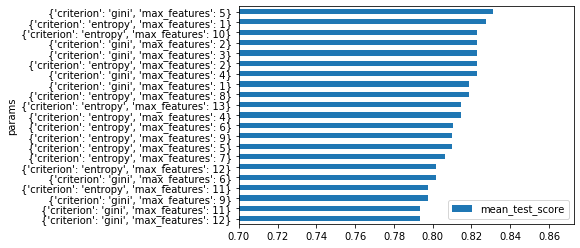

In [21]:
# top performing models
distinct_results[distinct_results.mean_test_score > 0.78].sort_values('mean_test_score').plot.barh(x='params', xlim=(0.7))

In [22]:
param_dist = {'criterion': ['gini', 'entropy'],'max_features': stats.randint(low=1, high=n_features),'max_depth':[1,3,5,7]}

In [23]:
# setting up the random search sampling 50 times and conducting 5-fold cross-validation
rscv = model_selection.RandomizedSearchCV(estimator=rfc, param_distributions=param_dist, n_iter=50, cv=5, scoring='accuracy' , random_state=100)
# start the process
rscv.fit(X_train,y_train)
results = pd.DataFrame(rscv.cv_results_)
# removing duplication
distinct_results = results.loc[:,['params','mean_test_score']]
# convert the params dictionaries to string data types
distinct_results.loc[:,'params'] = distinct_results.loc[:,'params'].astype('str')
# remove duplicates
distinct_results.drop_duplicates(inplace=True)
# look at the top 5 best hyperparamaterizations
distinct_results.sort_values('mean_test_score', ascending=False).head(5)

,params,mean_test_score
38,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.848316
4,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.840071
3,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",0.839805
11,"{'criterion': 'entropy', 'max_depth': 3, 'max_...",0.835727
0,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.831649


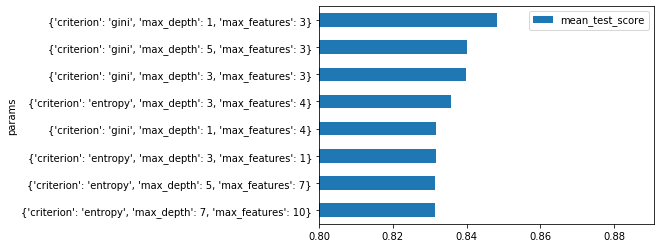

In [27]:
# top performing models
distinct_results[distinct_results.mean_test_score > 0.83].sort_values('mean_test_score').plot.barh(x='params', xlim=(0.8))